In [1]:
from pathlib import Path
import xarray as xr
import re
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import re
import seaborn as sns
import matplotlib
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.ticker import LogFormatter 
#np.random.seed(RNG_seed)

fatal: not a git repository (or any of the parent directories): .git


##  Plot longterm runs

In [2]:
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011//"

out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24

def read_output(file):
    ds = xr.open_dataset(file)#just use output_paticles for new data
    #add depth? time index
    #station = int(re.findall("\d{1}" ,out_files[1].name)[0]) 
    return ds

out_files

[PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week01_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week02_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week03_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week04_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week05_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2011/urchin_longterm2011_week06_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_

In [4]:
ds = xr.concat(map(read_output, out_files[::4]), dim="traj");#every 5th


print(ds.nbytes / 1e9, "GiB")
display(ds)

9.5004 GiB


<xarray.Dataset>
Dimensions:     (traj: 130000, obs: 1827)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.38 -16.39 -16.4 -16.41 ... nan nan nan
    lat         (traj, obs) float64 28.68 28.67 28.67 28.67 ... nan nan nan nan
    z           (traj, obs) float64 18.0 17.83 17.64 17.41 ... nan nan nan nan
    time        (traj, obs) datetime64[ns] 2011-01-03 2011-01-04 ... NaT NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [3]:
def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map


In [4]:
# test 
def plot_intg_heat(ds, title,save = False):

        #Border lat/lon of full domain
    lat_min = ds.lat.min().persist()
    lat_max = ds.lat.max().persist()
    lon_min = ds.lon.min().persist()
    lon_max = ds.lon.max().persist()

    print(f"lat in [{lat_min.compute().data}, {lat_max.compute().data}]")
    print(f"lon in [{lon_min.compute().data}, {lon_max.compute().data}]")
        #binsize

    dlat = 0.5 #binsize
    dlon = 0.5
    lat_bins = np.arange(lat_min.compute().data, lat_max.compute().data + dlat, dlat)
    lon_bins = np.arange(lon_min.compute().data, lon_max.compute().data + dlon, dlon)

            #heatmap and 95% contour 
    timeframe_ind = [int(365*24/output_dt_in_h), -1] #1year, 4 years
    particle_sum = ds.traj.size * ds.obs.size - ds.lon.isnull().sum('traj').sum() #traj intergated over time minus deleted particles(intg)

    textbox = ['1 year', '5 years']
    x_lines = np.arange(-50,25,10).tolist()
    y_lines = np.arange(-20,45,5).tolist()
    ticks = np.round(np.arange(0,.7,.1),1).tolist()#[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
    cb_pad = 0.07
    cb_fraction = 0.047
    proj = ccrs.PlateCarree()
  
    box_lon = -16.3
    box_lat = 28.4
    formatter = LogFormatter(10, labelOnlyBase=False)

    #cmap = cmocean.cm.dense
    new_cmap = cmocean.tools.crop_by_percent(cmocean.cm.dense, 10, which='min', N=None)


    fig, ax = plt.subplots(2, 1, subplot_kw={"projection": proj}, figsize=(15, 11))

    for i, ax in enumerate(ax.flat):

        int_heat = calculate_heatmap(ds.isel(obs = slice(0,timeframe_ind[i])), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs")

        lon = int_heat["lon_bin"]
        lat = int_heat["lat_bin"]

        plot_heat = (int_heat/particle_sum).where(int_heat > 0)
        (plot_heat*100).plot(ax = ax,cmap = new_cmap, norm=colors.SymLogNorm(linthresh=0.1, linscale=1,
                                                              vmin=0, vmax=0.7,
                                                                         base=10), extend = 'max') 

        cbar = ax.collections[-1].colorbar
        cbar.set_ticks(ticks, format = formatter)
        cbar.set_ticklabels(ticks)
        cbar.set_label('probability in %', rotation=270)

        quants = plot_heat.quantile(q=0.95) # 95% percentile
        hm_t = quants.coords["quantile"].where(plot_heat > quants)
        ax.contour(lon,lat, hm_t.fillna(0), colors = "00", linewidths = 0.2,antialiased = False)

        ax.coastlines()

        ax.add_feature(cartopy.feature.LAND,facecolor='gray',zorder = 2)
        ax.annotate(textbox[i],(-10,22.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
        ax.plot(box_lon,box_lat,markersize=10, marker="x", color="r", mew = 3)
        ax.set_extent((-50,15,-20,40))
        ax.set_xticks(x_lines, crs=proj)
        ax.set_yticks(y_lines, crs=proj)
        ax.xaxis.set_major_formatter(LongitudeFormatter())
        ax.yaxis.set_major_formatter(LatitudeFormatter()) 

        ax.set_title(title)
    plt.tight_layout()
    
    if save:
        plt.savefig('pics/' + save, dpi = 300, bbox_inches = 'tight')
        
    return

In [39]:
#distance covered for each larvea cycle
def plot_percentile_area(ds, q, title,interv = 180, save = False):

            #Border lat/lon of full domain
    lat_min = ds.lat.min().persist()
    lat_max = ds.lat.max().persist()
    lon_min = ds.lon.min().persist()
    lon_max = ds.lon.max().persist()


                #heatmap and 95% contour 
    dlat = 0.5 #binsize
    dlon = 0.5
    lat_bins = np.arange(lat_min.compute().data, lat_max.compute().data + dlat, dlat)
    lon_bins = np.arange(lon_min.compute().data, lon_max.compute().data + dlon, dlon)

    x_lines = np.arange(-50,25,10).tolist()
    y_lines = np.arange(-20,45,5).tolist()
    ticks = np.round(np.arange(0,.7,.1),1).tolist()#[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
    cb_pad = 0.07
    cb_fraction = 0.047
    proj = ccrs.PlateCarree()
    cmap_list = ['Purples','Blues', 'Greens', 'Reds', 'pink','Wistia']
    box_lon = -16.3
    box_lat = 28.4

        #cmap = cmocean.cm.dense

    fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(7, 6))


    timeframe_ind = np.arange(6,-1,-1) * interv # first five multiples of 180 days

    for i in range(timeframe_ind.shape[0]-1):
        int_heat = calculate_heatmap(ds.isel(obs = slice(timeframe_ind[i+1],timeframe_ind[i])), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs")

        lon = int_heat["lon_bin"]
        lat = int_heat["lat_bin"]

        plot_heat = int_heat.where(int_heat > 0)
        quants = plot_heat.quantile(q=q) # 50% percentile
        hm_t = quants.coords["quantile"].where(plot_heat > quants)#quants
        hm_t.plot(add_colorbar = False, cmap = cmap_list[i])

        ax.scatter(40,0, s = 100, c = matplotlib.colormaps[cmap_list[i]](0.5),marker = 's', label = f'{timeframe_ind[i]} days')
        #cs = ax.contour(lon,lat, hm_t.fillna(0), levels = [.5],antialiased = False)
        #plt.clabel(cs,inline=True ,fmt = f'{int(timeframe_ind[i]/180)}', fontsize=12)

    ax.coastlines()
    ax.legend(loc = 'center right')
    ax.set_title(title)
    ax.add_feature(cartopy.feature.LAND,facecolor='grey',zorder = 2)
    #ax.annotate(textbox[i],(-10,22.5),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )
    ax.plot(box_lon,box_lat,markersize=10, marker="x", color="r", mew = 3)

    ax.set_xticks(x_lines, crs=proj)
    ax.set_yticks(y_lines, crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())    
    ax.set_extent((-50,0,0,37))
    
    if save:
        plt.savefig('pics/' + save, dpi = 300, bbox_inches = 'tight')
        
    return

In [40]:
#full dataset
ds = xr.concat(map(read_output, out_files), dim="traj");#every 5th

print(ds.nbytes / 1e9, "GiB")
display(ds)

38.0016 GiB


<xarray.Dataset>
Dimensions:     (traj: 520000, obs: 1827)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.38 -16.39 -16.4 -16.41 ... nan nan nan
    lat         (traj, obs) float64 28.68 28.67 28.67 28.67 ... nan nan nan nan
    z           (traj, obs) float64 18.0 17.83 17.64 17.41 ... nan nan nan nan
    time        (traj, obs) datetime64[ns] 2011-01-03 2011-01-04 ... NaT NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

lat in [-16.712540810280814, 40.881491246792294]
lon in [-50.040047788373485, 14.716075331798818]


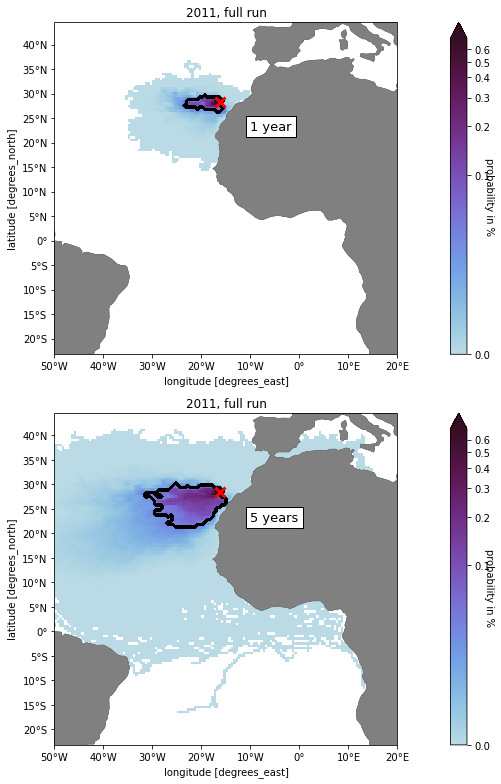

In [16]:
plot_intg_heat(ds,'2011, full run', save = 'long_2011_heat_all')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

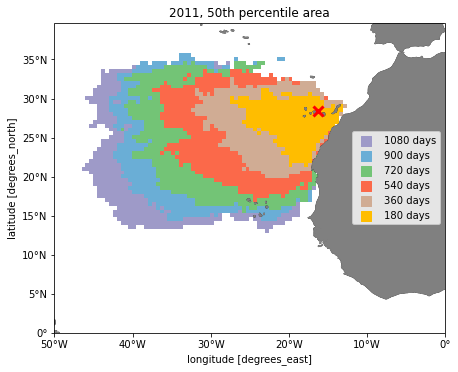

In [19]:
#ds = xr.concat(map(read_output, out_files[36::4]), dim="traj");#every 4th of JFM
plot_percentile_area(ds,q=0.5,title = '2011, 50th percentile area', save = 'long2011_percentile_50')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

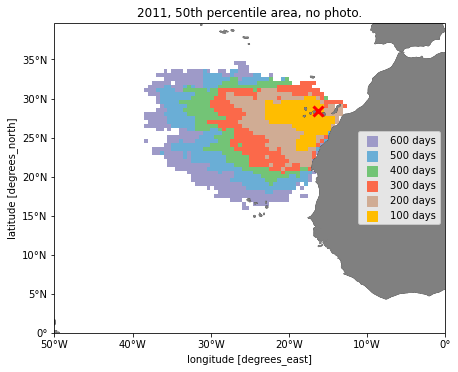

In [41]:
plot_percentile_area(ds,q=0.5,title = '2011, 50th percentile area, no photo.',interv = 100, save = 'long2011_percentile_50_100days')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

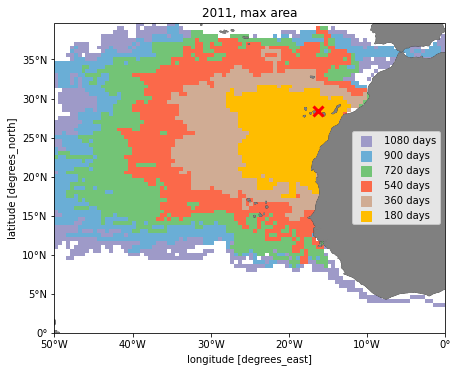

In [26]:
#ds = xr.concat(map(read_output, out_files[36::4]), dim="traj");#every 4th of JFM
plot_percentile_area(ds,q=0,title = '2011, max area', save = 'long2011_percentile_max')

In [30]:
#only JFM

ds = xr.concat(map(read_output, out_files[:12]), dim="traj");#every 5th
print(ds.nbytes / 1e9, "GiB")
display(ds)
#out_files[:12]


8.7696 GiB


<xarray.Dataset>
Dimensions:     (traj: 120000, obs: 1827)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.38 -16.39 -16.4 ... -39.91 -39.93 nan
    lat         (traj, obs) float64 28.68 28.67 28.67 28.67 ... 21.45 21.44 nan
    z           (traj, obs) float64 18.0 17.83 17.64 17.41 ... 109.1 107.7 nan
    time        (traj, obs) datetime64[ns] 2011-01-03 2011-01-04 ... NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 ... 9.999e+03 9.999e+03 nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

lat in [-8.722441077849872, 40.8767284583472]
lon in [-50.030542019771836, 14.71249572546447]


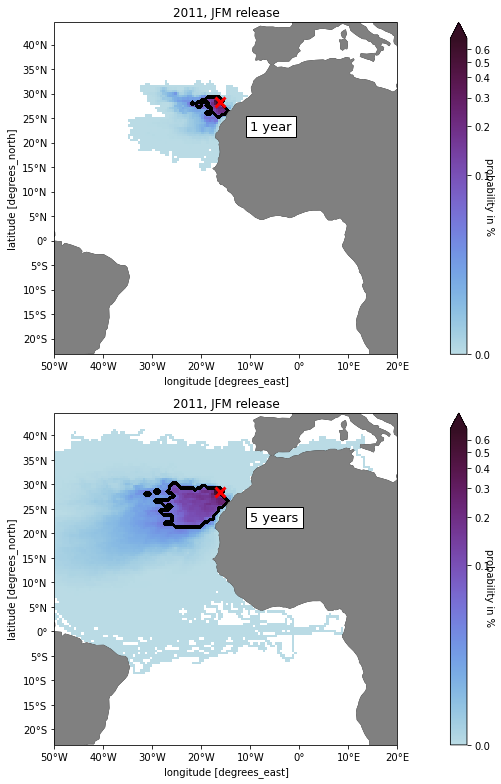

In [31]:
plot_intg_heat(ds,'2011, JFM release', save = 'long_2011_heat_JFM')

lat in [-16.712540810280814, 40.881491246792294]
lon in [-50.02138507260089, 4.916511593021484]


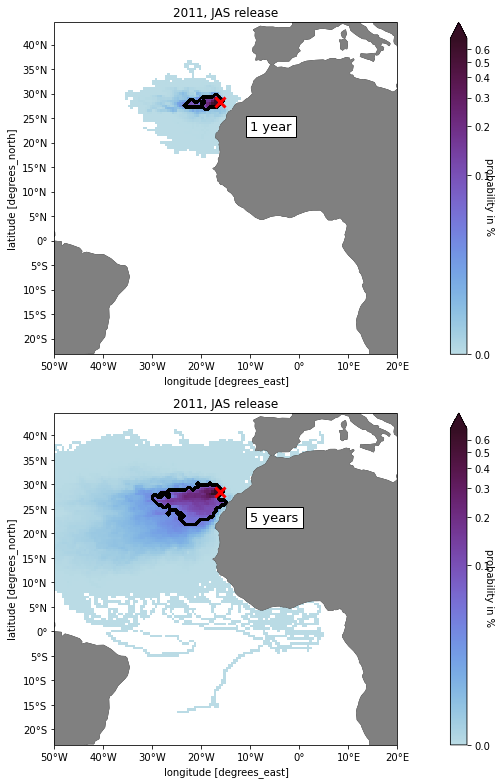

In [32]:
ds = xr.concat(map(read_output, out_files[25:38]), dim="traj") #only JAS
plot_intg_heat(ds,'2011, JAS release', save = 'long_2011_heat_JAS')

In [34]:
#load 2001 dataset 
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/"
out_files2 = sorted(Path(out_path).glob("*.nc"))
out_files2

ds = xr.concat(map(read_output, out_files2), dim="traj");#every 5th

print(ds.nbytes / 1e9, "GiB")
display(ds)


38.0016 GiB


<xarray.Dataset>
Dimensions:     (traj: 520000, obs: 1827)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.38 -16.32 -16.28 -16.23 ... nan nan nan
    lat         (traj, obs) float64 28.68 28.68 28.68 28.68 ... nan nan nan nan
    z           (traj, obs) float64 18.0 18.48 18.63 19.2 ... nan nan nan nan
    time        (traj, obs) datetime64[ns] 2001-01-01 2001-01-02 ... NaT NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

lat in [-19.878019203257843, 40.88350584898615]
lon in [-50.08743096724416, 14.947392797452315]


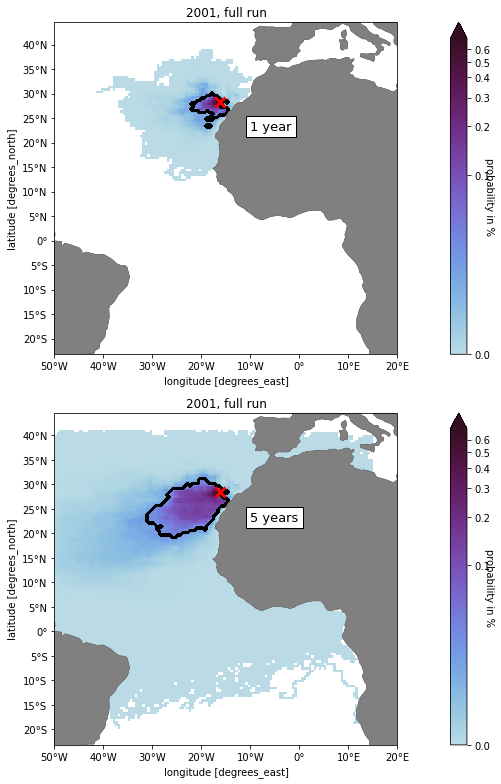

In [35]:
plot_intg_heat(ds,'2001, full run', save = 'long_2001_heat_all')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

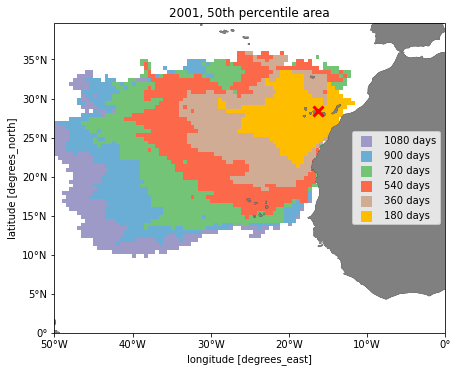

In [36]:
plot_percentile_area(ds,q=0.5,title = '2001, 50th percentile area', save = 'long2001_percentile_50')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

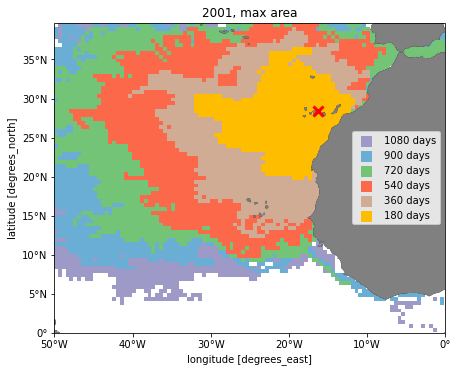

In [38]:
plot_percentile_area(ds,q=0,title = '2001, max area', save = 'long2001_percentile_max')

In [45]:
ds

<xarray.Dataset>
Dimensions:     (traj: 30000, obs: 1827)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 -16.38 -16.32 -16.28 -16.23 ... nan nan nan
    lat         (traj, obs) float64 28.68 28.68 28.68 28.68 ... nan nan nan nan
    z           (traj, obs) float64 18.0 18.48 18.63 19.2 ... nan nan nan nan
    time        (traj, obs) datetime64[ns] 2001-01-01 2001-01-02 ... NaT NaT
    trajectory  (traj, obs) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

In [82]:


lat_min = ds.lat.min().persist()
lat_max = ds.lat.max().persist()
lon_min = ds.lon.min().persist()
lon_max = ds.lon.max().persist()

print(f"lat in [{lat_min.compute().data}, {lat_max.compute().data}]")
print(f"lon in [{lon_min.compute().data}, {lon_max.compute().data}]")
        #binsize

dlat = 0.5 #binsize
dlon = 0.5
lat_bins = np.arange(lat_min.compute().data, lat_max.compute().data + dlat, dlat)
lon_bins = np.arange(lon_min.compute().data, lon_max.compute().data + dlon, dlon)

            #heatmap and 95% contour 
    #timeframe_ind = [int(365*24/output_dt_in_h), -1] #1year, 4 years
particle_sum = ds.traj.size * ds.obs.size - ds.lon.isnull().sum('traj').sum() #traj intergated over time minus deleted particles(intg)

y_lines = np.arange(-20,45,5).tolist()
ticks = np.round(np.arange(0,.7,.1),1).tolist()#[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7] 
cb_pad = 0.07
cb_fraction = 0.047
proj = ccrs.PlateCarree()
  

box_lat = 28.4
formatter = LogFormatter(10, labelOnlyBase=False)

    #cmap = cmocean.cm.dense
new_cmap = cmocean.tools.crop_by_percent(cmocean.cm.dense, 10, which='min', N=None)



ds = xr.concat(map(read_output, out_files2[:12]), dim="traj");#every 5th
int_heat_JFM01 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files2[12:24]), dim="traj");#every 5th
int_heat_AMJ01 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files2[24:36]), dim="traj");#every 5th
int_heat_JAS01 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files2[36:]), dim="traj");#every 5th
int_heat_OND01 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files[:12]), dim="traj");#every 5th
int_heat_JFM11 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files[12:24]), dim="traj");#every 5th
int_heat_AMJ11 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files[24:36]), dim="traj");#every 5th
int_heat_JAS11 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

ds = xr.concat(map(read_output, out_files[36:]), dim="traj");#every 5th
int_heat_OND11 = calculate_heatmap(ds.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins).sum("obs").sum('lon_bin')

lat in [-14.672861864019906, 40.88350584898615]
lon in [-50.05624947012202, 14.72076734506617]


In [81]:
particle_sum = ds.traj.size * ds.obs.size - ds.lon.isnull().sum('traj').sum()
#out_files2[12:24]
#out_files2[24:36]
#out_files2[36::]

[PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week25_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week26_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week27_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week28_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week29_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_weekly2001/urchin_longterm2001_week30_RT-1825_N-10000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_

In [89]:
int_heat_JFM01['lat_bin']

<xarray.DataArray 'lat_bin' (lat_bin: 112)>
array([-14.422862, -13.922862, -13.422862, -12.922862, -12.422862, -11.922862,
       -11.422862, -10.922862, -10.422862,  -9.922862,  -9.422862,  -8.922862,
        -8.422862,  -7.922862,  -7.422862,  -6.922862,  -6.422862,  -5.922862,
        -5.422862,  -4.922862,  -4.422862,  -3.922862,  -3.422862,  -2.922862,
        -2.422862,  -1.922862,  -1.422862,  -0.922862,  -0.422862,   0.077138,
         0.577138,   1.077138,   1.577138,   2.077138,   2.577138,   3.077138,
         3.577138,   4.077138,   4.577138,   5.077138,   5.577138,   6.077138,
         6.577138,   7.077138,   7.577138,   8.077138,   8.577138,   9.077138,
         9.577138,  10.077138,  10.577138,  11.077138,  11.577138,  12.077138,
        12.577138,  13.077138,  13.577138,  14.077138,  14.577138,  15.077138,
        15.577138,  16.077138,  16.577138,  17.077138,  17.577138,  18.077138,
        18.577138,  19.077138,  19.577138,  20.077138,  20.577138,  21.077138,
        21.577138,  22.077138,  22.577138,  23.077138,  23.577138,  24.077138,
        24.577138,  25.077138,  25.577138,  26.077138,  26.577138,  27.077138,
        27.577138,  28.077138,  28.577138,  29.077138,  29.577138,  30.077138,
        30.577138,  31.077138,  31.577138,  32.077138,  32.577138,  33.077138,
        33.577138,  34.077138,  34.577138,  35.077138,  35.577138,  36.077138,
        36.577138,  37.077138,  37.577138,  38.077138,  38.577138,  39.077138,
        39.577138,  40.077138,  40.577138,  41.077138])
Coordinates:
  * lat_bin  (lat_bin) float64 -14.42 -13.92 -13.42 -12.92 ... 40.08 40.58 41.08
Attributes:
    long_name:      
    standard_name:  latitude
    units:          degrees_north
    axis:           Y

/tmp/ipykernel_4109653/3223984013.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels( ['','JFM 2001', 'AMJ 2001', 'JAS 2001', 'OND 2001',


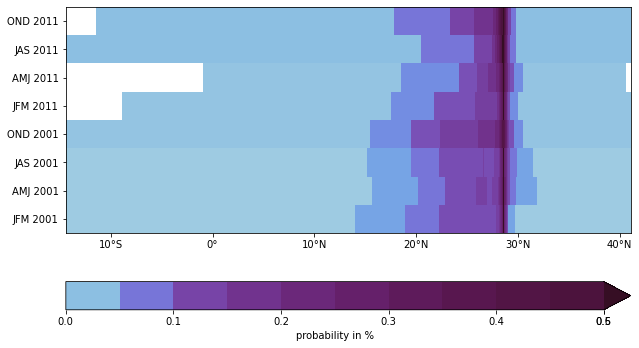

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

norm = colors.SymLogNorm(linthresh=0.1, linscale=1, vmin=0, vmax=.7,  base=10)
ticks = np.round(np.arange(0,.7,.1),1).tolist()
lat = int_heat_JFM01['lat_bin']
y = np.arange(-.5,1.5,1)
X,Y = np.meshgrid(lat,y)

def plot_sect(int_heat):
    plot_heat = (int_heat/particle_sum).where(int_heat > 0)
    return np.stack((plot_heat,plot_heat))
    
    
    
plot_heatJFM01 = plot_sect(int_heat_JFM01)
plot_heatAMJ01 = plot_sect(int_heat_AMJ01)
plot_heatJAS01 = plot_sect(int_heat_JAS01)
plot_heatOND01 = plot_sect(int_heat_OND01)

plot_heatJFM11 = plot_sect(int_heat_JFM11)
plot_heatAMJ11 = plot_sect(int_heat_AMJ11)
plot_heatJAS11 = plot_sect(int_heat_JAS11)
plot_heatOND11 = plot_sect(int_heat_OND11)


ax.contourf(X,Y,plot_heatJFM01, cmap = new_cmap,norm=norm, extend = 'max',levels = 11) 
ax.contourf(X,Y+1,plot_heatAMJ01, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)
ax.contourf(X,Y+2,plot_heatJAS01, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)
ax.contourf(X,Y+3,plot_heatOND01, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)

ax.contourf(X,Y+4,plot_heatJFM11, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)
ax.contourf(X,Y+5,plot_heatAMJ11, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)
ax.contourf(X,Y+6,plot_heatJAS11, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)
cf = ax.contourf(X,Y+7,plot_heatOND11, cmap = new_cmap,norm=norm, extend = 'max',levels = 11)


cbar = fig.colorbar(cf, location = 'bottom')
cbar.set_ticks(ticks, format = formatter)
cbar.set_ticklabels(ticks)
cbar.set_label('probability in %')


ax.set_xticks(np.round(np.arange(-10,50,10),1).tolist())
ax.xaxis.set_major_formatter(LatitudeFormatter())

ax.set_yticklabels( ['','JFM 2001', 'AMJ 2001', 'JAS 2001', 'OND 2001',
         'JFM 2011', 'AMJ 2011', 'JAS 2011', 'OND 2011'])

plt.tight_layout()
plt.savefig('pics/cross_section.png', dpi = 300, bbox_inches = 'tight')

In [109]:
y_list = ['JFM 2001', 'AMJ 2001', 'JAS 2001', 'OND 2001',
         'JFM 2011', 'AMJ 2011', 'JAS 2011', 'OND 2011']

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

Text(0.5, 0, 'days')

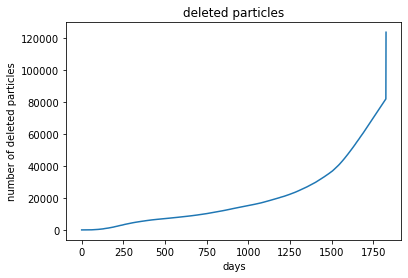

In [70]:
ds.lon.isnull().sum("traj").plot()
plt.title('deleted particles')
plt.ylabel('number of deleted particles')
plt.xlabel('days')
#plt.ylim(0,5000)
#plt.xlim(0,200)
#plt.legend()
    #loss of ~300 due to boundary limits
#plt.savefig('pics/particle_deletion_no_m.png', dpi = 300, bbox_inches = 'tight')